# Introduction and Background

The creation of artworks by machines using algorithms without human input has become increasingly common in recent years. This project aims to train a neural network image classifier to determine whether an artwork is AI or human-generated, in which human classification ability is considered the baseline. Of course, discriminating between AI-generated and human-generated art isn't straightforward. It involves deciphering subtle nuances in style, strokes, and artistic choices, which can be a complex task even for human experts.


This project brings multiple real-world advantages, including the ability to discern AI-generated art from human-generated art. This approach can have practical applications in areas such as copyright protection, authentication of artworks, and even the development of new AI-generated art styles.


The model is built by training it on datasets from both Human Artwork and AI-generated artwork. Once filtered and preprocessed, the model is trained using a CNN architecture and evaluated on both the test set and new samples from human artists and AI-generated images with different generative tools. The following diagram shows a brief description of the project.




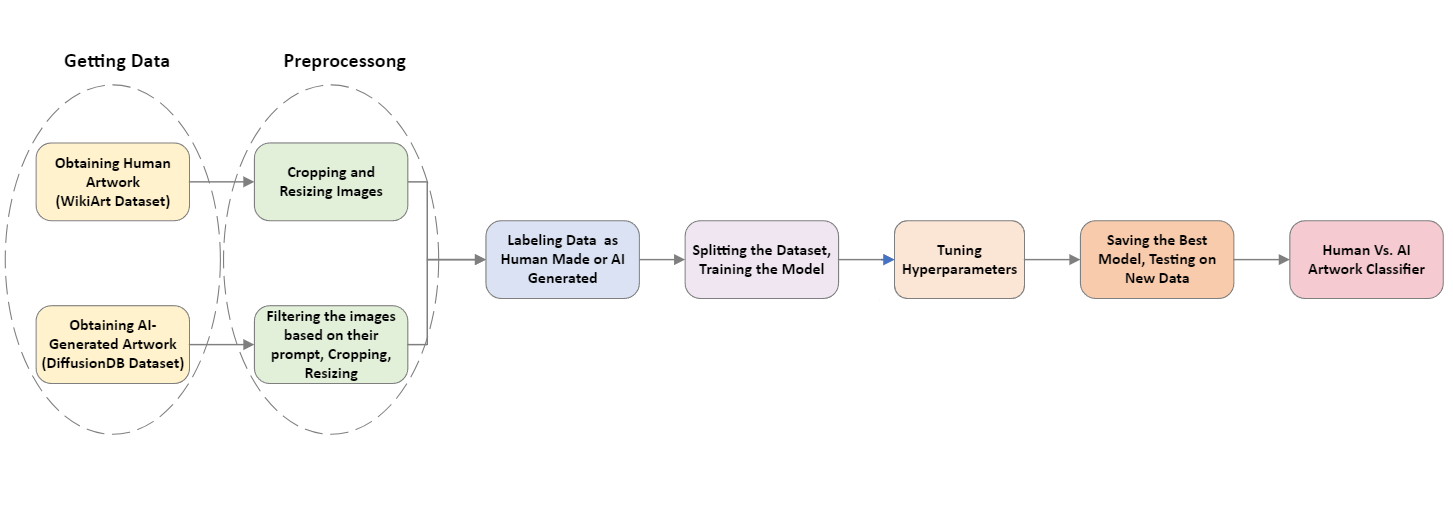

# Configuration and Setup

Some requirements must be met before the main code can be started, including importing the necessary libraries and setting the GPU into use.

## Imports

In [ ]:
# utils
from google.colab import drive
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import pdb
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import json
import datetime
import datetime
import glob


# torch
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.io import read_image
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter


# sklearn
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

## Config

In [ ]:
# pytorch gpu config
seed = 0
torch.manual_seed(seed)
if torch.cuda.is_available():
  device = torch.device("cuda")
  torch.cuda.manual_seed_all(seed)
else:
  device = torch.device("cpu")
print(device)

cuda


# Obtaining and Processong the Datasets

As indicated, this model is bulit on two main datasets. The WikiArt dataset, which is sliced based on movements and genres related to specific works of art, containing real paintings from actual artists, and the DiffusuinDB, containing millions of AI-generated images and the prompts that were used to create them. To keep the images that meet the requirements of this project and make a fair, balanced comparison of the images, we need to filter the images based on specific words in the prompts. It means keeping the prompts that include words like "painting" or the name of an artist and excluding the ones that include words like "digital" and "3D", which makes the images easily recognizable by human eyes.

The next step is cropping the images. Clearly, the sizes of the actual paintings or the AI-generated ones are not fully compatible and need to be matched. Our approach involves cropping a random square of 256 pixels by 256 pixels to ensure matching dimensions, more straightforward computation, and covering different parts of the artwork (instead of only focusing on the center of each painting.)

Here are the links to the code for loading and preprocessing the "Wikiart Dataset" and the "DiffusionDB" datasets.

[WikiArt Dataset Retrival Code](https://colab.research.google.com/drive/1WYA-sdHHdf7feagV0UQ7xvSJigqrcKRh?usp=sharing)

[DiffusionDB Dataset Retrival Code](https://colab.research.google.com/drive/10CF_aH9Uis7DAnLld_v373NySh4gYI3e?usp=sharing)

The following links provide direct access to these data sources:

[Wikiart Source](https://huggingface.co/datasets/huggan/wikiart)

[DiffusionDB Source](https://huggingface.co/datasets/poloclub/diffusiondb)



In [ ]:
# download the datasets to working directory
!gdown 1G_xAySbkTofD-3ol6tBwmWizKEOoiH3v # diffusiondb_256
!gdown 1vEfcY7Ta0SC2p04eDFHcQokcsDMGaTNw # paintings_256

# create directories for data and unzip archives
!mkdir -p /content/diffusiondb
!mkdir -p /content/wikiart
!unzip -u /content/cropped_diffusiondb_256.zip -d /content/diffusiondb
!unzip -u /content/cropped_paintings_256.zip -d /content/wikiart

Downloading...
From: https://drive.google.com/uc?id=1G_xAySbkTofD-3ol6tBwmWizKEOoiH3v
To: /content/cropped_diffusiondb_256.zip
 81% 185M/228M [00:09<00:01, 27.2MB/s]

## Creating Custom Dataset

In [ ]:
# define wikiart metadata lookup lists
wikiart_artists = ["Unknown Artist", "boris-kustodiev", "camille-pissarro", "childe-hassam", "claude-monet", "edgar-degas", "eugene-boudin", "gustave-dore", "ilya-repin", "ivan-aivazovsky", "ivan-shishkin", "john-singer-sargent", "marc-chagall", "martiros-saryan", "nicholas-roerich", "pablo-picasso", "paul-cezanne", "pierre-auguste-renoir", "pyotr-konchalovsky", "raphael-kirchner", "rembrandt", "salvador-dali", "vincent-van-gogh", "hieronymus-bosch", "leonardo-da-vinci", "albrecht-durer", "edouard-cortes", "sam-francis", "juan-gris", "lucas-cranach-the-elder", "paul-gauguin", "konstantin-makovsky", "egon-schiele", "thomas-eakins", "gustave-moreau", "francisco-goya", "edvard-munch", "henri-matisse", "fra-angelico", "maxime-maufra", "jan-matejko", "mstislav-dobuzhinsky", "alfred-sisley", "mary-cassatt", "gustave-loiseau", "fernando-botero", "zinaida-serebriakova", "georges-seurat", "isaac-levitan", "joaqu\u00e3\u00adn-sorolla", "jacek-malczewski", "berthe-morisot", "andy-warhol", "arkhip-kuindzhi", "niko-pirosmani", "james-tissot", "vasily-polenov", "valentin-serov", "pietro-perugino", "pierre-bonnard", "ferdinand-hodler", "bartolome-esteban-murillo", "giovanni-boldini", "henri-martin", "gustav-klimt", "vasily-perov", "odilon-redon", "tintoretto", "gene-davis", "raphael", "john-henry-twachtman", "henri-de-toulouse-lautrec", "antoine-blanchard", "david-burliuk", "camille-corot", "konstantin-korovin", "ivan-bilibin", "titian", "maurice-prendergast", "edouard-manet", "peter-paul-rubens", "aubrey-beardsley", "paolo-veronese", "joshua-reynolds", "kuzma-petrov-vodkin", "gustave-caillebotte", "lucian-freud", "michelangelo", "dante-gabriel-rossetti", "felix-vallotton", "nikolay-bogdanov-belsky", "georges-braque", "vasily-surikov", "fernand-leger", "konstantin-somov", "katsushika-hokusai", "sir-lawrence-alma-tadema", "vasily-vereshchagin", "ernst-ludwig-kirchner", "mikhail-vrubel", "orest-kiprensky", "william-merritt-chase", "aleksey-savrasov", "hans-memling", "amedeo-modigliani", "ivan-kramskoy", "utagawa-kuniyoshi", "gustave-courbet", "william-turner", "theo-van-rysselberghe", "joseph-wright", "edward-burne-jones", "koloman-moser", "viktor-vasnetsov", "anthony-van-dyck", "raoul-dufy", "frans-hals", "hans-holbein-the-younger", "ilya-mashkov", "henri-fantin-latour", "m.c.-escher", "el-greco", "mikalojus-ciurlionis", "james-mcneill-whistler", "karl-bryullov", "jacob-jordaens", "thomas-gainsborough", "eugene-delacroix", "canaletto"]
wikiart_genres = ["abstract_painting", "cityscape", "genre_painting", "illustration", "landscape", "nude_painting", "portrait", "religious_painting", "sketch_and_study", "still_life", "Unknown Genre"]
wikiart_styles = ["Abstract_Expressionism", "Action_painting", "Analytical_Cubism", "Art_Nouveau", "Baroque", "Color_Field_Painting", "Contemporary_Realism", "Cubism", "Early_Renaissance", "Expressionism", "Fauvism", "High_Renaissance", "Impressionism", "Mannerism_Late_Renaissance", "Minimalism", "Naive_Art_Primitivism", "New_Realism", "Northern_Renaissance", "Pointillism", "Pop_Art", "Post_Impressionism", "Realism", "Rococo", "Romanticism", "Symbolism", "Synthetic_Cubism", "Ukiyo_e"]

In [ ]:
wikiart_artists[115]

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, directory, label, max_images=None):
        self.directory = directory
        self.label = label
        self.images = [file for file in os.listdir(directory) if file.endswith('.jpg')]
        self.side_info = [file for file in os.listdir(directory) if file.endswith('.json')]
        self.transform = transforms.ToTensor()

        # If max_images is set, randomly select a subset of images
        if max_images is not None and max_images <= len(self.images):
            self.images = random.sample(self.images, max_images)
            self.side_info = random.sample(self.side_info, max_images)

        # sort images and side_info
        self.images.sort()
        self.side_info.sort()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.directory, self.images[idx])
        image = Image.open(img_path)
        image = self.transform(image)  # Transform the image to a tensor
        # load image with gpu if available
        if torch.cuda.is_available():
            image = image.to(torch.device('cuda:0'))
        # load side info
        side_info_path = os.path.join(self.directory, self.side_info[idx])
        with open(side_info_path, 'r') as file:
          side_info = json.load(file)
          # add wikiart metadata for wikiart class
          if self.label:
            side_info['artist'] = wikiart_artists[int(side_info['artist'])]
            side_info['genre'] = wikiart_genres[int(side_info['genre'])]
            side_info['style'] = wikiart_styles[int(side_info['style'])]

        return image, str(side_info), self.label


# Determine the number of images in the smaller dataset
num_images_in_smaller_dataset = len([file for file in os.listdir('/content/diffusiondb') if file.endswith('.jpg')])

# for testing purposes, use small dataset size
data_size = num_images_in_smaller_dataset


# Create dataset with true and false labels
dataset_false = CustomImageDataset('/content/diffusiondb', 0, max_images=data_size)
dataset_true = CustomImageDataset('/content/wikiart', 1, max_images=data_size) # since wikiart has more samples, set max

# Concat datasets into one
combined_dataset = ConcatDataset([dataset_false, dataset_true])

In [ ]:
# Train-Validation-Test Split
length_of_combined_dataset = len(combined_dataset)
print(f'Length of dataset: {length_of_combined_dataset}')

# define split size
train_size = int(0.7 * length_of_combined_dataset)  # 70% for training
val_size = int(0.1 * length_of_combined_dataset)   # 10% for validation
test_size = length_of_combined_dataset - train_size - val_size  # Remaining 20% for testing

# perform the split
train_dataset, val_dataset, test_dataset = random_split(combined_dataset, [train_size, val_size, test_size])

{'prompt': 'portrait of russian asian model girl jodhpurs hyperborea winter traveler treasure hunter decollete greg manchess painting by sargent and leyendecker, fantasy, medium shot, asymmetrical, intricate, elegant, matte painting, illustration, hearthstone, by rhads, by greg rutkowski, by greg tocchini, by james gilleard, by joe fenton '}
{'prompt': 'an immense gigantic ornated iron chalice cup with a lake inside, water in excess droping by thomas cole and gediminas pranckevicius '}
{'prompt': 'an hd goth emo punk portrait painted by pablo picasso. her hair is dark brown and cut into a short, messy pixie cut. she has a slightly rounded face, with a pointed chin, large entirely - black eyes, and a small nose. she is wearing a black tank top, a black leather jacket, a black knee - length skirt, and a black choker. '}
{'prompt': 'anya taylor as the lady of the lake by williamdyce and dante gabriel rossetti and william morris and william waterhouse '}


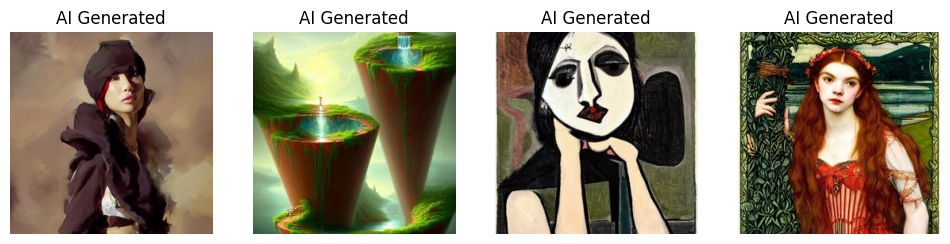

In [ ]:
# randomly display a few images from the dataset

def show_random_images(dataset, num_images=4):
    indices = random.sample(range(len(dataset)), num_images)

    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(indices):
        image, side_info, label = dataset[idx]
        print(side_info)
        # Convert the tensor back to a PIL Image for display
        image = transforms.ToPILImage()(image)

        plt.subplot(2, num_images, i + 1)
        plt.imshow(image)
        real_or_fake_label = {1 : 'Human-Made', 0 : 'AI Generated'}
        plt.title(f'{real_or_fake_label[label]}')
        plt.axis('off')

    plt.show()

# Display random images from the combined dataset
show_random_images(train_dataset)

# Model Structure


Our model is a **Convolutional Neural Network (CNN)** to analyze and classify artworks. This model is made of two parts: **Encoder** and **Classifier**.

The encoder reduces spatial dimensions and essentially performs feature extraction on the image input. The output from the encoder is then flattened and fed into the fully connected layers of the classifier section.

The classifier takes these features and learns non-linear combinations of them to form the final decision. This final layer utilizes a sigmoid activation function for binary classification, producing an output between 0 and 1, forming a probability distribution over whether an image is Human Artwork (1) or AI Generated (0).

The following diagram represents the main structure of the model:

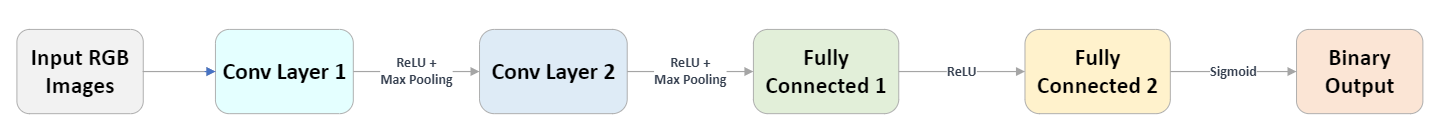

## Model Definition
Here we define the model's architecture along with helper functions for saving and loading checkpoints

In [ ]:
# helper for checkpointing
def checkpoint_model(model, optimizer, train_loss, val_loss, epoch, checkpoint_dir='checkpoints'):
    # Create a directory if it doesn't exist
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    # Generate a unique identifier for the checkpoint filename
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

    # Construct the checkpoint filename
    checkpoint_filename = f"{timestamp}_epoch{epoch}_train_loss{train_loss:.4f}_val_loss{val_loss:.4f}.pth"

    # Save the checkpoint
    checkpoint_path = os.path.join(checkpoint_dir, checkpoint_filename)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
    }, checkpoint_path)

    return checkpoint_path

# helper for loading checkpoints
def load_checkpoint(model, optimizer, checkpoint_dir='checkpoints'):
    checkpoint_files = glob.glob(os.path.join(checkpoint_dir, '*.pth'))

    if checkpoint_files:
        # find newest
        latest_checkpoint_path = max(checkpoint_files, key=os.path.getctime)
        # load check point
        checkpoint = torch.load(latest_checkpoint_path)
        # load checkpoint info
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        train_loss = checkpoint['train_loss']
        val_loss = checkpoint['val_loss']
        print(f"Loaded checkpoint from epoch {epoch} with train loss {train_loss:.4f} and val loss {val_loss:.4f}")
        return model, optimizer, epoch, train_loss, val_loss
    else:
        print("No checkpoint found. Starting from scratch.")
        return model, optimizer, 0, None, None


In [ ]:
class MyConvNet(nn.Module):
  def __init__(self, lr=0.01, criterion=nn.BCELoss):
    super(MyConvNet, self).__init__()

    # define params
    self.lr = lr
    self.criterion = criterion()


    # build the encoder and classifier
    self.encoder = self.build_encoder()
    self.classifier = self.build_classifier()


  def build_encoder(self):
    encoder = nn.Sequential(
      nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 5, stride = 2, padding = 0), # (8,254,254) / (8,126,126)
      nn.ReLU(),
      nn.MaxPool2d(kernel_size = 4, stride = 1, padding = 0), # (8, 251, 251) / (8,123,123)
      nn.Conv2d(in_channels = 8, out_channels = 10, kernel_size = 9, stride = 2, padding = 0), # (10,122,122) / (10,58,58)
      nn.ReLU(),
      nn.MaxPool2d(kernel_size = 4, stride = 1 , padding = 0), # (10, 119, 119) / (10,55,55)
      )
    return encoder

  def build_classifier(self):
    classifier = nn.Sequential(
      nn.Flatten(start_dim=1),
      nn.Linear(10*55**2, 128),
      nn.ReLU(),
      nn.Linear(128, 1),
      nn.Sigmoid()
    )
    return classifier


  def forward(self, img):
    return self.classifier(self.encoder(img.to(torch.float)))

  def train(self, data, val_data, n_epochs=10, batch_size=5, max_batches_per_epoch=300, optimizer=torch.optim.Adam):
    # read params and assign
    self.batch_size = batch_size
    train_loader = DataLoader(dataset=data, shuffle=True, batch_size=self.batch_size)
    val_loader = DataLoader(dataset=val_data, shuffle=True, batch_size=self.batch_size)

    # define optimizer
    self.optimizer = optimizer(self.parameters(), lr = self.lr)
    n_training_steps = max_batches_per_epoch
    n_val_steps = len(val_loader)


    train_losses_epochs = []
    val_losses_epochs = []
    train_accuracy_epochs = []
    val_accuracy_epochs =[]

    for epoch in range(n_epochs):
      output = []
      batch_accuracies = []
      train_losses = []
      # training loop
      train_batch_count = 0
      for i, (x_train, _, y_train) in enumerate(train_loader):
        if max_batches_per_epoch and train_batch_count >= max_batches_per_epoch:
              print("Breaking out of training loop after processing", train_batch_count, "batches")
              break
        # fix typing of labels
        y_train = y_train.type(torch.FloatTensor).unsqueeze(1)
        # make sure we are using cuda
        if torch.cuda.is_available():
          x_train = x_train.to(torch.device('cuda:0'))
          y_train = y_train.to(torch.device('cuda:0'))
        # forward step
        y_pred = self.forward(x_train)
        # get loss
        loss = self.criterion(y_pred, y_train)

        # backprop
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        # add outputs to list
        output.append(y_pred)
        # add loss to list
        train_losses.append(loss.item())

        # get accuracy
        correct = (y_pred.round() == y_train).type(torch.float).sum().item()
        accuracy_batch = 100*correct/len(x_train)
        batch_accuracies.append(accuracy_batch)
        train_batch_count += 1

        # print batch info
        if (train_batch_count == n_training_steps):
          avg_loss = sum(train_losses)/len(train_losses)
          # add average loss to training losses
          train_losses_epochs.append(avg_loss)
          # get accuracy of epoch
          accuracy = sum(batch_accuracies)/len(batch_accuracies)
          train_accuracy_epochs.append(accuracy)
          # print current epoch info
          print(f'Epoch {epoch+1}/{n_epochs} : Train Accuracy: {accuracy:.2f}%, Avg Loss: {avg_loss:.4f}')


      # validation loop
      batch_accuracies = []
      val_losses = []
      val_batch_count = 0
      for i, (x_val, _, y_val) in enumerate(val_loader):
        # fix typing of labels
        y_val = y_val.type(torch.FloatTensor).unsqueeze(1)
        if torch.cuda.is_available():
          x_val = x_val.to(torch.device('cuda:0'))
          y_val = y_val.to(torch.device('cuda:0'))
        # forward step
        y_val_pred = self.forward(x_val)
        # get loss
        loss = self.criterion(y_val_pred, y_val)
        # get accuracy
        correct = (y_val_pred.round() == y_val).type(torch.float).sum().item()
        accuracy_batch = 100*correct/len(x_val)
        batch_accuracies.append(accuracy_batch)
        val_losses.append(loss.item())
        val_batch_count += 1

        if (i+1 == n_val_steps):
          # get loss and accuracy
          avg_loss = sum(val_losses)/len(val_losses)
          accuracy = sum(batch_accuracies)/len(batch_accuracies)
          val_accuracy_epochs.append(accuracy)
          # add average loss to validation losses
          val_losses_epochs.append(avg_loss)
          print(f'Epoch {epoch+1}/{n_epochs} : Validation Accuracy: {accuracy:.2f}%, Validation Loss: {avg_loss:.4f}')

      # Save model checkpoint
      print(train_losses_epochs, val_losses_epochs)
      checkpoint_model(self, self.optimizer, train_losses_epochs[-1], val_losses_epochs[-1], epoch+1)

    return train_losses_epochs, val_losses_epochs, train_accuracy_epochs, val_accuracy_epochs, output

## Model Training
For model training, we first check to see if an existing checkpoint exists in the corresponding checkpoints directory '/checkpoints/' by default, and if so, load it. Otherwise, we train the model from its intialization. During training, the training set and validation set accuracy and loss values are computed and saved at each epoch for debugging purposes and for later metric calculations

In [ ]:
# init net
net = MyConvNet(lr=1e-4)
# use gpu if available
if torch.cuda.is_available():
  net = net.to(torch.device('cuda:0'))

# load from checkpoint if it exists
model, optimizer, epoch, train_loss, val_loss = load_checkpoint(net, torch.optim.Adam(net.parameters(), lr = net.lr))
# train from scratch if no checkpoint exists
if epoch == 0:
  train_losses, val_losses, train_accuracy, val_accuracy, output = net.train(train_dataset, val_dataset, batch_size=16, n_epochs=45,  max_batches_per_epoch=400)
  print('Finished Training')

Loaded checkpoint from epoch 24 with train loss 0.2752 and val loss 0.3024


### Training Visualization

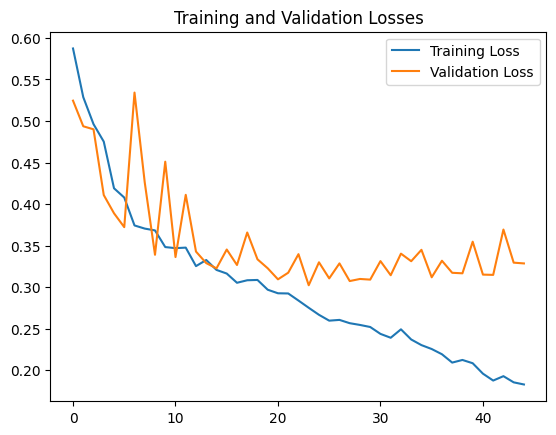

In [ ]:
# plot the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

# add title and legend
plt.legend()
plt.title('Training and Validation Losses')

# display plot
plt.show()

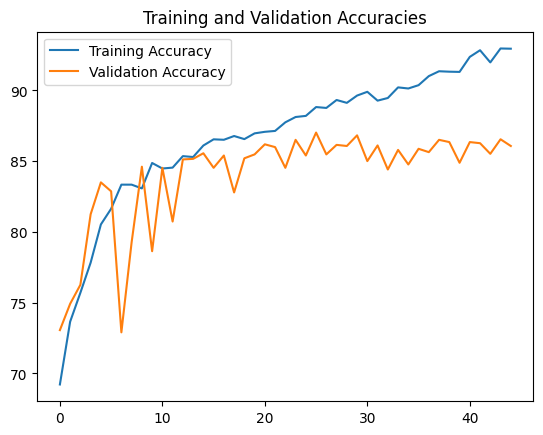

In [ ]:
# plot the training and validation losses
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')

# add title and legend
plt.legend()
plt.title('Training and Validation Accuracies')

# display plot
plt.show()

## Model Evaluation

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

test_preds = []
test_labels = []
total_correct = 0
total_predictions = 0

# test loop
for x_test, _, y_test in test_loader:
    # fix typing of labels
    y_test = y_test.type(torch.FloatTensor).unsqueeze(1)
    if torch.cuda.is_available():
        x_test = x_test.to(torch.device('cuda:0'))
        y_test = y_test.to(torch.device('cuda:0'))

    # Get predictions
    y_pred = net.forward(x_test)

    # Round predictions to the nearest integer (0 or 1) and convert to CPU for further processing
    test_preds.extend(y_pred.round().type(torch.int).cpu().numpy().flatten().tolist())

    # Convert true labels to CPU and add to the list
    test_labels.extend(y_test.cpu().numpy().flatten().tolist())

    # Calculate number of correct predictions
    correct = (y_pred.round() == y_test).type(torch.float).sum().item()
    total_correct += correct
    total_predictions += len(x_test)

# Calculate and print test accuracy
test_accuracy = 100 * total_correct / total_predictions
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 86.50%


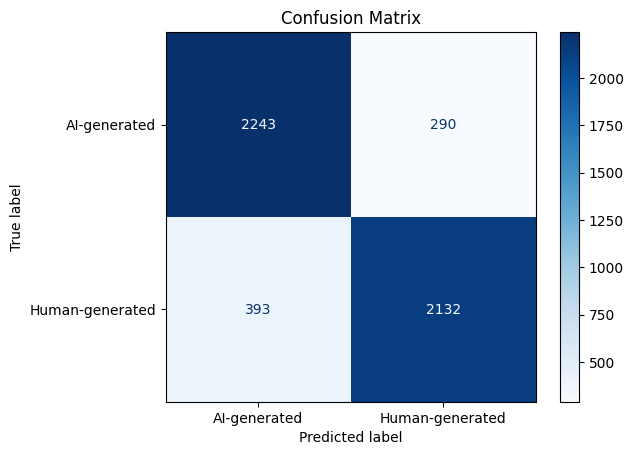

Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.89      0.87      2533
         1.0       0.88      0.84      0.86      2525

    accuracy                           0.86      5058
   macro avg       0.87      0.86      0.86      5058
weighted avg       0.87      0.86      0.86      5058



In [ ]:
# create confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["AI-generated", "Human-generated"])
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix")
plt.show()

# display classification report
report = classification_report(test_labels, test_preds)
print("Classification Report:\n", report)

# Analysis & Commentary

**Performance Benchmark** - For general ML tasks, a good bechmark can be human-level performance. The task of recognizing Human vs AI generated images is relatively new, so few thorough studies have been conducted on this topic. However, one peer-reviewed study has been conducted which assess Human performance on this very task. "The role of AI Attribution Knowledge in the Evaluation of Artwork" (Gangadharbatla, 2022) conducted a study with 211 participants through Amazon Mechanical Turk where part classify art as AI or Human generated. On aggregate, the participants had an accuracy rate of just 55%. When looking only at AI-generated art, it was only correctly labelled 43% of the time, while they correctly identified Human-generated art 84% of the time. If we weight these equally, we obtain an overall accuracy score of 63%.


**Performance of our Model**

Our model achieves a test accuracy of 86.5%, far exceeding human level performance. Intuitively, this seems surprising, especially considering the relatively simple 4-layer architecture of our neural network. Even after a single epoch, and with a very small batch size of just 3 images, our model achieves near-human performance.



# Saliency Maps

A saliency map is a visualization technique to understand which parts of an input image are most important for a model's prediction. It highlights the regions or features within an image that contribute the most to the model's decision-making process.

In this project, we used saliency maps to understand better why the model is making a particular prediction and validate whether the model attends to the relevant parts of the input.

In [ ]:
# Load trained model
model = net

# Convert image to tensor
def image_to_tensor(img_path):
    image = Image.open(img_path).convert('RGB')
    transform = transforms.ToTensor()
    image = transform(image).unsqueeze(0)
    return image

# helper for normalizing gradients
def prep_output(img_tensor):
    invTrans = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ],
                                                    std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                            transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                    std = [ 1., 1., 1. ]),
                            ])
    out = invTrans(img_tensor)[0]
    out = out.detach().numpy().transpose(1, 2, 0)

    return out


# normalize gradient image
def norm_flat_image(img):
    grads_norm = prep_output(img)
    grads_norm = grads_norm[:,:,0]+ grads_norm[:,:,1]+ grads_norm[:,:,2]
    grads_norm = (grads_norm - np.min(grads_norm))/ (np.max(grads_norm)- np.min(grads_norm))
    return grads_norm

# Calculate saliency map
def saliency_map(image_path, model):
    image = image_to_tensor(image_path)
    image = Variable(image, requires_grad=True)

    # tell the model to compute gradients for input image
    image.requires_grad = True
    # forward pass
    output = model(image.cuda())
    # print prediction info
    predicted_label = 'Human-generated' if output.cpu().detach().item() > 0.5 else 'AI-generated'
    confidence = output.cpu().detach().item() if output.cpu().detach().item() > 0.5 else 1-output.cpu().detach().item()
    print(f'Prediction: {predicted_label} | Confidence: {100*confidence:.2f}%')
    model.zero_grad()
    output.backward()
    saliency = norm_flat_image(image.grad.data)

    return saliency


def plot_image_saliency_and_overlay(img_path, saliency_map, alpha=0.75):
    # Load and display the original image
    original_image = Image.open(img_path).convert('RGBA')
    original_image_np = np.array(original_image)

    plt.figure(figsize=(18, 6))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    # Saliency map
    plt.subplot(1, 3, 2)
    plt.imshow(saliency_map, cmap='viridis')
    plt.title('Saliency Map')
    plt.axis('off')

    # Overlaid image
    plt.subplot(1, 3, 3)
    #plt.imshow(overlaid_image)
    plt.imshow(original_image)
    plt.imshow(saliency_map, cmap='bone', alpha = alpha)
    plt.title('Overlaid Image')
    plt.axis('off')

    plt.show()

Prediction: AI-generated | Confidence: 99.27%
5531


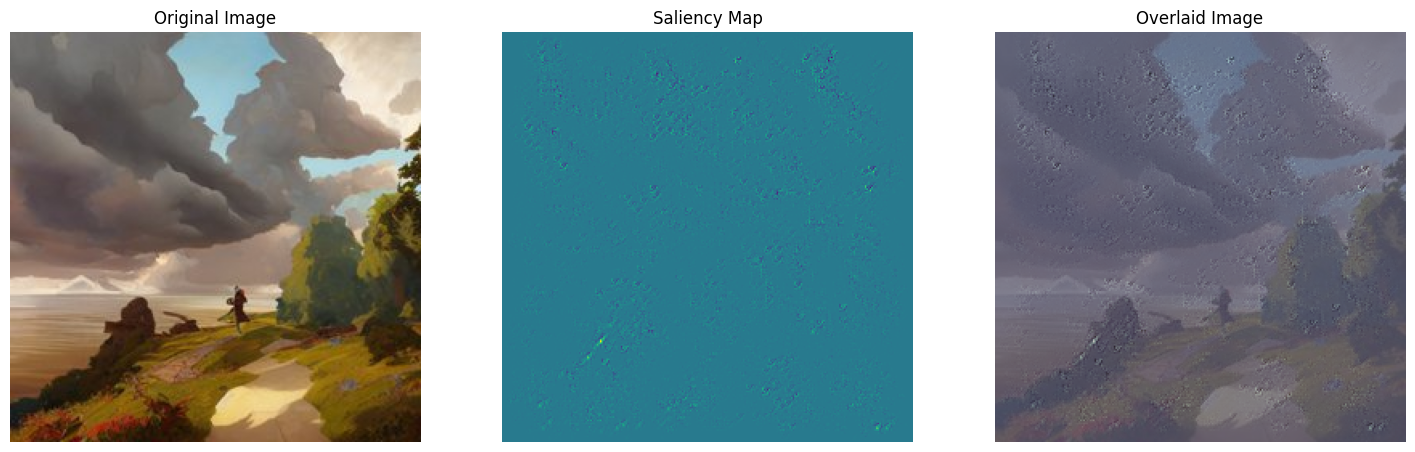

In [ ]:
# get random saliency map
random_sample_num = str(random.randint(0,num_images_in_smaller_dataset))

image_path = r'diffusiondb/cropped_image_' + random_sample_num + '.jpg'
saliency = saliency_map(image_path, model)
print(random_sample_num)
plot_image_saliency_and_overlay(image_path, saliency)

# Discussion

As human beings, we have our unique approach to detecting Human versus AI-generated artworks. We unconsciously expect the model to distinguish the images by using similar metrics, e.g., detecting the work being fake from obvious signs like face, fingers, or an unusual object in the image.

However, using Saliency Maps helps us see what the model is actually learning, which brings new insights to our analysis. In many cases, it seems like the model relies heavily on the edges of the objects in the painting to distinguish them. In some others, the detection appears to be based on a random element in the image that might not indicate anything to us.

Considering the acceptable performance of the model and its superiority over human detection on both the original dataset and the newly tested data from different sources, it is clear that the model's method of detecting fake and actual artwork is practical (with plenty of room for improvement, of course). However, it might not be practical to interpret how these detections are made entirely.

Multiple factors contribute to this, including Abstract Representations. As we know, Neural networks often learn abstract representations of features. The model might focus on aspects of the image that are not easily discernible to humans, such like pixel textures, patterns, or color distributions in certain regions, rather than easily human-recognizable objects or shapes.

Overall, interpreting how these models make decisions in distinguishing between human and AI-generated artwork can be intricate and might not align with human intuition. Even though the model's performance is satisfactory and meets our standards, for future work, we believe it's crucial to develop methods for interpretability and transparency in AI models, especially in domains where human understanding and performance work as the baseline. This helps ensure trust, fairness, and reliability in deploying and using such models.




